In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from os.path import join
import sys
import json
import geopandas as gpd

In [2]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [3]:
# add the 'src' directory as one where we can import modules
src_dir = join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [4]:
%aimport Data.make_data
from Data.make_data import states_in_nerc
%aimport Analysis.index
from Analysis.index import facility_emission_gen, group_facility_data
%aimport Analysis.index
from Analysis.index import facility_co2, adjust_epa_emissions, group_fuel_cats
from Analysis.index import reduce_emission_factors, add_datetime
%aimport util.utils
from util.utils import rename_cols, add_facility_location

## Extra NERC emissions and generation

### Load extra NERC generation and fuel consumption

In [5]:
cwd = os.getcwd()
path = join(cwd, '..', 'Data storage', 'NERC extra gen fuels_rev.csv')
extra_nerc = pd.read_csv(path, index_col=[0, 1, 2, 3])

In [6]:
extra_nerc.head()

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)
year nerc month type                                                         
2016 SERC 1     COW       1.250252e+05        4.777255e+06       1.075619e+06
                HYC       1.578592e+06                 NaN                NaN
                NG        6.487438e+05        1.456982e+07       5.659672e+06
                OOG       2.896880e+04                 NaN                NaN
                OTH       1.081877e+05                 NaN                NaN

### Load emission factors

In [7]:
path = join(cwd, '..', 'Data storage', 'Final emission factors.csv')
ef = pd.read_csv(path, index_col=0)

In [8]:
ef.head()

,Fuel,Fossil Factor,Notes,Link,Total Factor
EIA Fuel Code,,,,,
BIT,Bituminous Coal,93.30,NaN,https://www.eia.gov/electricity/annual/html/ep...,93.30
DFO,Distillate Fuel Oil,73.16,NaN,https://www.eia.gov/electricity/annual/html/ep...,73.16
GEO,Geothermal,7.71,NaN,https://www.eia.gov/electricity/annual/html/ep...,7.71
JF,Jet Fuel,70.90,NaN,https://www.eia.gov/electricity/annual/html/ep...,70.90
KER,Kerosene,72.30,NaN,https://www.eia.gov/electricity/annual/html/ep...,72.30


In [9]:
ef_type = reduce_emission_factors(ef)

In [10]:
ef_type = pd.Series(ef_type, name='type')
ef_type

COW     95.250
NG      53.070
OOG     59.000
PC     102.100
PEL     75.975
Name: type, dtype: float64

### Calculate CO₂ emissions

In [11]:
extra_nerc.loc[:, 'total co2 (kg)'] = (extra_nerc
                                       .loc[:, 'total fuel (mmbtu)']
                                       .multiply(ef_type, 'type'))
extra_nerc.loc[:, 'elec co2 (kg)'] = (extra_nerc
                                       .loc[:, 'elec fuel (mmbtu)']
                                       .multiply(ef_type, 'type'))

In [31]:
extra_nerc.sort_index(inplace=True)
extra_nerc.head()

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)  \
year nerc month type                                                            
2016 -    1     COW       41906.627497        1.191174e+06      282550.319599   
                HYC       41084.477887                 NaN                NaN   
                NG         4616.426184        1.396837e+05       43306.395889   
                PEL         229.742217        1.099033e+03         965.454965   
                WND        1154.326185                 NaN                NaN   

                      total co2 (kg)  elec co2 (kg)  
year nerc month type                                 
2016 -    1     COW     1.134594e+08   2.691292e+07  
                HYC              NaN            NaN  
                NG      7.413013e+06   2.298270e+06  
                PEL     8.349906e+04   7.335044e+04  
                WND              NaN            NaN

## Facilities by NERC

In [13]:
%aimport Analysis.state2nerc
from Analysis.state2nerc import fraction_state2nerc, add_region

In [14]:
fuel_cat_folder = join(cwd, '..', 'Data storage', 'Fuel categories')
state_cats_path = join(fuel_cat_folder, 'State_facility.json')

with open(state_cats_path, 'r') as f:
    state_fuel_cat = json.load(f)
    
custom_cats_path = join(fuel_cat_folder, 'Custom_results.json')
with open(custom_cats_path, 'r') as f:
    custom_fuel_cat = json.load(f)

In [15]:
path = join(cwd, '..', 'Data storage', 'Derived data',
            'Monthly EPA emissions 2017-08-31.csv')
epa = pd.read_csv(path)

In [16]:
path = join(cwd, '..', 'Data storage', 'Facility labels',
            'Facility locations.csv')
facility_labels = pd.read_csv(path)

In [17]:
path = join(cwd, '..', 'Data storage',
            'Facility gen fuels and CO2 2017-08-31.zip')
eia_fac = pd.read_csv(path)

In [18]:
eia_fac.head()

,f,fuel,month,plant id,total fuel (mmbtu),year,generation (MWh),elec fuel (mmbtu),geography,last_updated,lat,lon,prime mover,datetime,quarter,all fuel fossil CO2 (kg),elec fuel fossil CO2 (kg),all fuel total CO2 (kg),elec fuel total CO2 (kg)
0,M,SUB,6,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-06-01,2,0.0,0.0,0.0,0.0
1,M,SUB,5,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-05-01,2,0.0,0.0,0.0,0.0
2,M,SUB,4,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-04-01,2,0.0,0.0,0.0,0.0
3,M,SUB,3,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-03-01,1,0.0,0.0,0.0,0.0
4,M,SUB,2,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-02-01,1,0.0,0.0,0.0,0.0


In [19]:
co2, gen_fuels_state = facility_emission_gen(eia_facility=eia_fac, epa=epa,
                                              state_fuel_cat=state_fuel_cat,
                                              custom_fuel_cat=custom_fuel_cat,
                                              export_state_cats=True)

Renaming columns
Grouping facilities
Adjusting EPA emissions
Caculating CO2
Gen/fuels to state categories


### Monthly CO₂ emissions

In [20]:
co2 = add_facility_location(co2, facility_labels, labels=['lat', 'lon', 'state', 'nerc'])

In [21]:
co2_nerc = co2.groupby(['year', 'nerc', 'month'])['final co2 (kg)'].sum()

In [22]:
co2_nerc.tail()

year  nerc  month
2017  WECC  2        1.797939e+10
            3        1.622878e+10
            4        1.410046e+10
            5        1.635295e+10
            6        1.998163e+10
Name: final co2 (kg), dtype: float64

### Monthly generation

In [125]:
gen_fuels_nerc = add_facility_location(gen_fuels_state, facility_labels, labels=['nerc'])
gen_fuels_nerc = (gen_fuels_nerc
                  .groupby(['year', 'nerc', 'month', 'type'])
                  ['generation (mwh)'].sum())
gen_fuels_nerc.head()

year  nerc  month  type
2001  -     1      COW     4984145.332
                   HYC      278484.523
                   NG       245740.990
                   NUC     1599398.000
                   PEL       77892.543
Name: generation (mwh), dtype: float64

In [59]:
gen_fuels_nerc.tail()

year  nerc  month  type
2017  WECC  6      PEL       19776.466
                   SUN     1502622.000
                   WAS       42851.264
                   WND     1048324.000
                   WWW      163238.315
Name: generation (mwh), dtype: float64

In [120]:
gen_fuels_nerc.loc[idx[2015, 'NPCC', :, :]].groupby(['year', 'nerc', 'month']).sum()

year  nerc  month
2015  NPCC  1        2.018215e+07
            2        1.908706e+07
            3        1.912367e+07
            4        1.730879e+07
            5        1.920187e+07
            6        1.981127e+07
            7        2.319538e+07
            8        2.314866e+07
            9        1.990933e+07
            10       1.815993e+07
            11       1.776335e+07
            12       1.891339e+07
Name: generation (mwh), dtype: float64

## Combine generation

In [33]:
extra_nerc.head()

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)  \
year nerc month type                                                            
2016 -    1     COW       41906.627497        1.191174e+06      282550.319599   
                HYC       41084.477887                 NaN                NaN   
                NG         4616.426184        1.396837e+05       43306.395889   
                PEL         229.742217        1.099033e+03         965.454965   
                WND        1154.326185                 NaN                NaN   

                      total co2 (kg)  elec co2 (kg)  
year nerc month type                                 
2016 -    1     COW     1.134594e+08   2.691292e+07  
                HYC              NaN            NaN  
                NG      7.413013e+06   2.298270e+06  
                PEL     8.349906e+04   7.335044e+04  
                WND              NaN            NaN

In [119]:
extra_nerc.loc[idx[2016, 'NPCC', :, 'COW']].groupby(['year', 'nerc', 'month']).sum()

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)  \
year nerc month                                                            
2016 NPCC 1              1781.561             88950.0             7740.0   
          2              1680.029             85480.0             7306.0   
          3              1610.380             85363.0             6993.0   
          4              1260.521             32030.0             5473.0   
          5              1385.229             64251.0             6020.0   
          6              1387.296             67956.0             6025.0   
          7              1550.546             68293.0             6740.0   
          8              1613.617             71512.0             7007.0   
          9              1269.466             56083.0             5516.0   
          10             1217.757             41950.0             5291.0   
          11             1244.606             56777.0             5406.0   
          12             1547.191             62437.0             6718.0   

                 total co2 (kg)  elec co2 (kg)  
year nerc month                                 
2016 NPCC 1          8472487.50      737235.00  
          2          8141970.00      695896.50  
          3          8130825.75      666083.25  
          4          3050857.50      521303.25  
          5          6119907.75      573405.00  
          6          6472809.00      573881.25  
          7          6504908.25      641985.00  
          8          6811518.00      667416.75  
          9          5341905.75      525399.00  
          10         3995737.50      503967.75  
          11         5408009.25      514921.50  
          12         5947124.25      639889.50

In [27]:
idx = pd.IndexSlice

In [199]:
total_gen = gen_fuels_nerc.copy()
# total_gen.loc[idx[2015:, 'RFC', :, :]]

In [200]:
total_gen.loc[idx[2016:, :, :, :]] = (total_gen.loc[2016:] 
                                     .add(extra_nerc.loc[:, 'generation (mwh)']
                                          , fill_value=0))
total_gen = total_gen.reset_index()
add_datetime(total_gen)
# total_gen.set_index(['year', 'nerc', ''])

In [201]:
total_gen.head()

,year,nerc,month,type,generation (mwh),datetime
0,2001,-,1,COW,4984145.332,2001-01-01
1,2001,-,1,HYC,278484.523,2001-01-01
2,2001,-,1,NG,245740.990,2001-01-01
3,2001,-,1,NUC,1599398.000,2001-01-01
4,2001,-,1,PEL,77892.543,2001-01-01


In [202]:
final = group_fuel_cats(total_gen,
                        custom_fuel_cat, 'type',
                        'fuel category', extra_group_cols=['nerc', 'datetime'])
final.set_index(['nerc', 'fuel category', 'datetime'], inplace=True)

In [203]:
final.head()

,,,year,month,generation (mwh)
nerc,fuel category,datetime,,,
-,Coal,2001-01-01,2001,1,4.984145e+06
FRCC,Coal,2001-01-01,2001,1,5.667654e+06
MRO,Coal,2001-01-01,2001,1,1.135828e+07
NPCC,Coal,2001-01-01,2001,1,4.033044e+06
RFC,Coal,2001-01-01,2001,1,5.187368e+07


In [204]:
final.tail()

,,,year,month,generation (mwh)
nerc,fuel category,datetime,,,
RFC,Wind,2017-06-01,2017,6,1.461436e+06
SERC,Wind,2017-06-01,2017,6,7.369026e+05
SPP,Wind,2017-06-01,2017,6,6.135980e+06
TRE,Wind,2017-06-01,2017,6,2.278518e+06
WECC,Wind,2017-06-01,2017,6,3.252146e+06


In [205]:
total = final.groupby(['nerc', 'datetime']).sum()
# total.reset_index(inplace=True)
# add_datetime(total)
# total['fuel category'] = 'Total'
total.head()

year  month  generation (mwh)
nerc datetime                                  
-    2001-01-01  10005      5       7185661.388
     2001-02-01  10005     10       6526739.453
     2001-03-01  10005     15       6304139.884
     2001-04-01  10005     20       6624660.323
     2001-05-01  10005     25       7045482.729

In [206]:
nercs = total.index.get_level_values('nerc').unique()

### Percent generation by fuel
    

In [207]:
df_list = []
for nerc in nercs:
    percent_gen = final.loc[nerc].divide(total.loc[nerc], level='datetime')
    percent_gen['nerc'] = nerc
    percent_gen.set_index('nerc', append=True, inplace=True)
    df_list.append(percent_gen)
    
percent_gen = pd.concat(df_list)

In [226]:
percent_gen.head()

year  month  generation (mwh)
fuel category datetime   nerc                               
Coal          2001-01-01 -      0.2    0.2          0.693624
              2001-02-01 -      0.2    0.2          0.616249
              2001-03-01 -      0.2    0.2          0.601500
              2001-04-01 -      0.2    0.2          0.621707
              2001-05-01 -      0.2    0.2          0.637201

In [228]:
path = join(cwd, '..', 'Data storage', 'Final NERC data', 'NERC percent gen.csv')
percent_gen.to_csv(path)

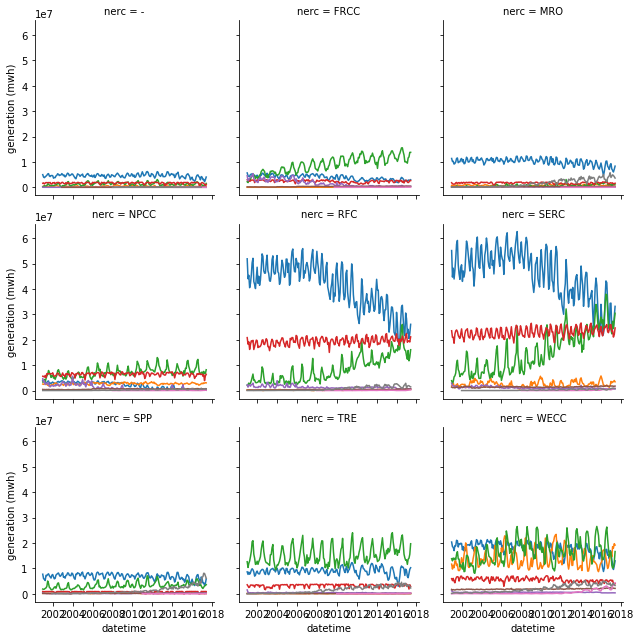

In [211]:
g = sns.FacetGrid(final.reset_index(), col='nerc', col_wrap=3, hue='fuel category')
g.map(plt.plot, 'datetime', 'generation (mwh)')

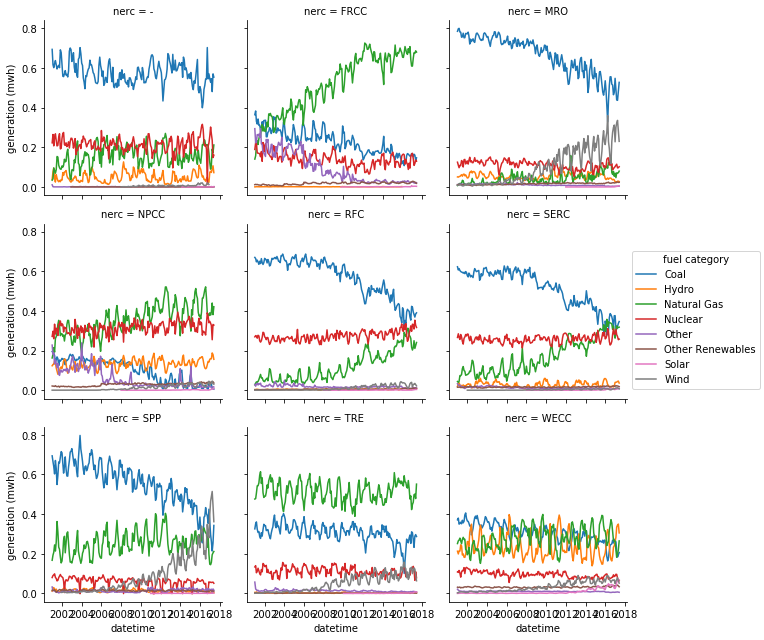

In [212]:
g = sns.FacetGrid(percent_gen.reset_index(), col='nerc', col_wrap=3, hue='fuel category')
g.map(plt.plot, 'datetime', 'generation (mwh)').add_legend()

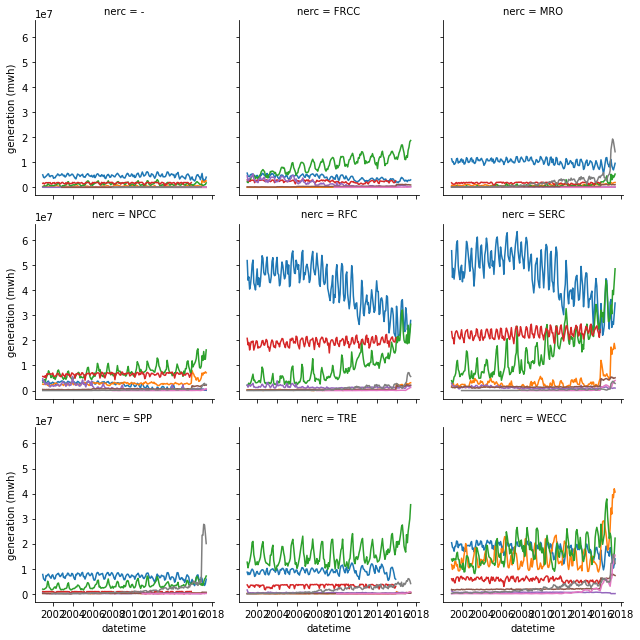

In [94]:
g = sns.FacetGrid(final, col='nerc', col_wrap=3, hue='fuel category')
g.map(plt.plot, 'datetime', 'generation (mwh)')

In [213]:
total_monthly_gen = final.groupby(['year', 'nerc', 'month'])['generation (mwh)'].sum()

In [214]:
total_monthly_gen.head()

year  nerc  month
2001  -     1        7185661.388
            2        6526739.453
            3        6304139.884
            4        6624660.323
            5        7045482.729
Name: generation (mwh), dtype: float64

In [104]:
nercs

Index(['-', 'FRCC', 'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC'], dtype='object', name='nerc')

In [215]:
total_monthly_gen.loc[idx[2016, 'NPCC', :]]

year  nerc  month
2016  NPCC  1        2.021002e+07
            2        1.870887e+07
            3        1.834471e+07
            4        1.720541e+07
            5        1.864431e+07
            6        1.911649e+07
            7        2.296379e+07
            8        2.353870e+07
            9        1.897689e+07
            10       1.739688e+07
            11       1.700507e+07
            12       1.886310e+07
Name: generation (mwh), dtype: float64

## CO₂ emissions intensity by NERC region

In [127]:
co2_nerc.head()

year  nerc  month
2001  -     1        5.476076e+09
            2        4.349473e+09
            3        4.223575e+09
            4        4.544873e+09
            5        4.972656e+09
Name: final co2 (kg), dtype: float64

In [128]:
type(co2_nerc), type(total_monthly_gen)

(pandas.core.series.Series, pandas.core.series.Series)

In [216]:
nerc_index = pd.concat([co2_nerc.sort_index(), total_monthly_gen.sort_index()], axis=1)
nerc_index['index'] = nerc_index['final co2 (kg)'] / nerc_index['generation (mwh)']
nerc_index = nerc_index.reset_index()
add_datetime(nerc_index)

In [217]:
nerc_index.tail()

,year,nerc,month,final co2 (kg),generation (mwh),index,datetime
1777,2017,WECC,2,1.797939e+10,5.143480e+07,349.556798,2017-02-01
1778,2017,WECC,3,1.622878e+10,5.554224e+07,292.188030,2017-03-01
1779,2017,WECC,4,1.410046e+10,5.206520e+07,270.823055,2017-04-01
1780,2017,WECC,5,1.635295e+10,5.642293e+07,289.828162,2017-05-01
1781,2017,WECC,6,1.998163e+10,6.282335e+07,318.060592,2017-06-01


### Write data to file

In [224]:
nerc_index.head()

final co2 (kg)  generation (mwh)       index   datetime
nerc year month                                                         
-    2001 1        5.476076e+09       7185661.388  762.083771 2001-01-01
          2        4.349473e+09       6526739.453  666.408193 2001-02-01
          3        4.223575e+09       6304139.884  669.968545 2001-03-01
          4        4.544873e+09       6624660.323  686.053817 2001-04-01
          5        4.972656e+09       7045482.729  705.793523 2001-05-01

In [225]:
path = join(cwd, '..', 'Data storage', 'Final NERC data',
            'NERC gen emissions and index.csv')
nerc_index.to_csv(path)

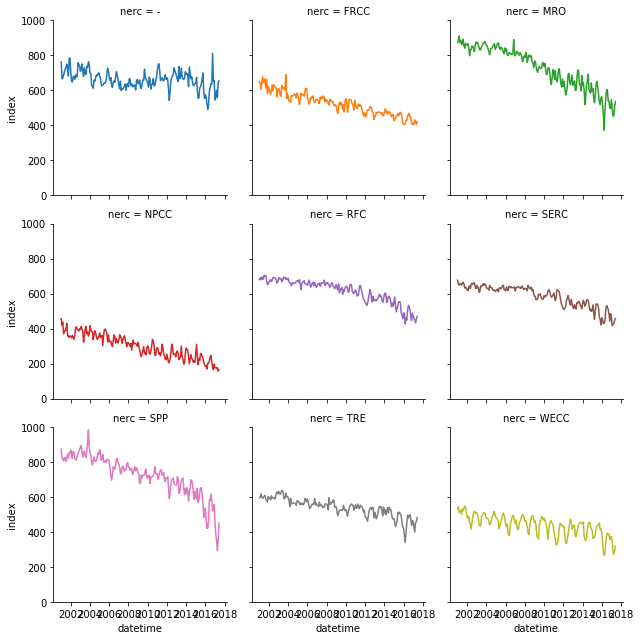

In [218]:
g = sns.FacetGrid(nerc_index, col='nerc', col_wrap=3, hue='nerc')
g.map(plt.plot, 'datetime', 'index')
g.set(ylim=(0, 1000))

In [219]:
nerc_index.set_index(['nerc', 'year', 'month'], inplace=True)
nerc_index.sort_index(inplace=True)

In [220]:
nerc_index.head()

final co2 (kg)  generation (mwh)       index   datetime
nerc year month                                                         
-    2001 1        5.476076e+09       7185661.388  762.083771 2001-01-01
          2        4.349473e+09       6526739.453  666.408193 2001-02-01
          3        4.223575e+09       6304139.884  669.968545 2001-03-01
          4        4.544873e+09       6624660.323  686.053817 2001-04-01
          5        4.972656e+09       7045482.729  705.793523 2001-05-01

In [221]:
nerc_index.loc[idx['RFC', [2015, 2016], :]]

final co2 (kg)  generation (mwh)       index   datetime
nerc year month                                                         
RFC  2015 1        4.306783e+10      7.783863e+07  553.296296 2015-01-01
          2        4.263669e+10      7.343447e+07  580.608713 2015-02-01
          3        3.679073e+10      6.970127e+07  527.834464 2015-03-01
          4        2.828605e+10      5.710803e+07  495.307651 2015-04-01
          5        3.231308e+10      6.272971e+07  515.116141 2015-05-01
          6        3.677572e+10      6.869253e+07  535.367126 2015-06-01
          7        4.232129e+10      7.648261e+07  553.345283 2015-07-01
          8        4.159511e+10      7.505784e+07  554.174043 2015-08-01
          9        3.837479e+10      6.971716e+07  550.435332 2015-09-01
          10       3.023574e+10      6.177795e+07  489.426034 2015-10-01
          11       2.935812e+10      6.109637e+07  480.521521 2015-11-01
          12       2.883434e+10      6.308340e+07  457.082838 2015-12-01
     2016 1        3.626499e+10      7.411975e+07  489.275724 2016-01-01
          2        3.226399e+10      6.618790e+07  487.460489 2016-02-01
          3        2.617552e+10      6.120764e+07  427.651158 2016-03-01
          4        2.656983e+10      5.762905e+07  461.049263 2016-04-01
          5        2.706978e+10      6.038847e+07  448.260692 2016-05-01
          6        3.520189e+10      6.987611e+07  503.775732 2016-06-01
          7        4.294938e+10      8.074331e+07  531.924999 2016-07-01
          8        4.409355e+10      8.366931e+07  526.997935 2016-08-01
          9        3.513746e+10      6.976534e+07  503.652138 2016-09-01
          10       2.906225e+10      6.198996e+07  468.821809 2016-10-01
          11       2.727237e+10      6.111087e+07  446.276917 2016-11-01
          12       3.530546e+10      7.224450e+07  488.694083 2016-12-01

In [149]:
extra_nerc.head()

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)  \
year nerc month type                                                            
2016 -    1     COW       41906.627497        1.191174e+06      282550.319599   
                HYC       41084.477887                 NaN                NaN   
                NG         4616.426184        1.396837e+05       43306.395889   
                PEL         229.742217        1.099033e+03         965.454965   
                WND        1154.326185                 NaN                NaN   

                      total co2 (kg)  elec co2 (kg)  
year nerc month type                                 
2016 -    1     COW     1.134594e+08   2.691292e+07  
                HYC              NaN            NaN  
                NG      7.413013e+06   2.298270e+06  
                PEL     8.349906e+04   7.335044e+04  
                WND              NaN            NaN

In [151]:
extra_nerc.loc[idx[[2015, 2016], 'RFC', :, :]].groupby(['month']).sum()

,generation (mwh),total fuel (mmbtu),elec fuel (mmbtu),total co2 (kg),elec co2 (kg)
month,,,,,
1,2.975293e+06,2.654826e+07,1.746824e+07,1.851243e+09,1.240129e+09
2,2.330573e+06,2.369033e+07,1.400473e+07,1.707539e+09,1.016863e+09
3,2.348359e+06,2.398724e+07,1.417536e+07,1.691622e+09,9.937365e+08
4,2.174804e+06,2.102326e+07,1.268165e+07,1.456520e+09,8.732754e+08
5,2.278637e+06,2.194446e+07,1.359598e+07,1.537301e+09,9.452902e+08
6,2.633743e+06,2.501806e+07,1.638540e+07,1.766071e+09,1.153384e+09
7,3.049505e+06,2.975092e+07,2.038828e+07,2.046732e+09,1.396636e+09
8,3.174413e+06,3.092805e+07,2.145855e+07,2.112901e+09,1.458313e+09
9,2.474695e+06,2.455273e+07,1.621045e+07,1.703640e+09,1.127224e+09
